# Simple inversion
Here we will walkthrough a very simple gravity inversion using synthetic data. The goal of the inversion is to recover the geometry of a layer. In this case, the layer is simply the surface of the Earth, which is represented by the density contrast between air and rock.

## Import packages
We need to import each of the necessary *Invert4Geom* packages, as well as a few others.

In [ ]:
from __future__ import annotations

%load_ext autoreload
%autoreload 2

import logging

import verde as vd
import xarray as xr
from polartoolkit import maps
from polartoolkit import utils as polar_utils

from invert4geom import inversion, plotting, regional, synthetic, utils

# set up logging to see what's going on
logging.basicConfig(level=logging.INFO)

## Create observed gravity data
To run the inversion, we need to have observed gravity data. In this simple example, we will first create a synthetic topography, which represents the `true` Earth topography which we hope to recover during the inverison. From this topography, we will create a layer of vertical right-rectangular prisms, which allows us to calculated the gravity effect of the topography. This will act as our observed gravity data. 

### True topography

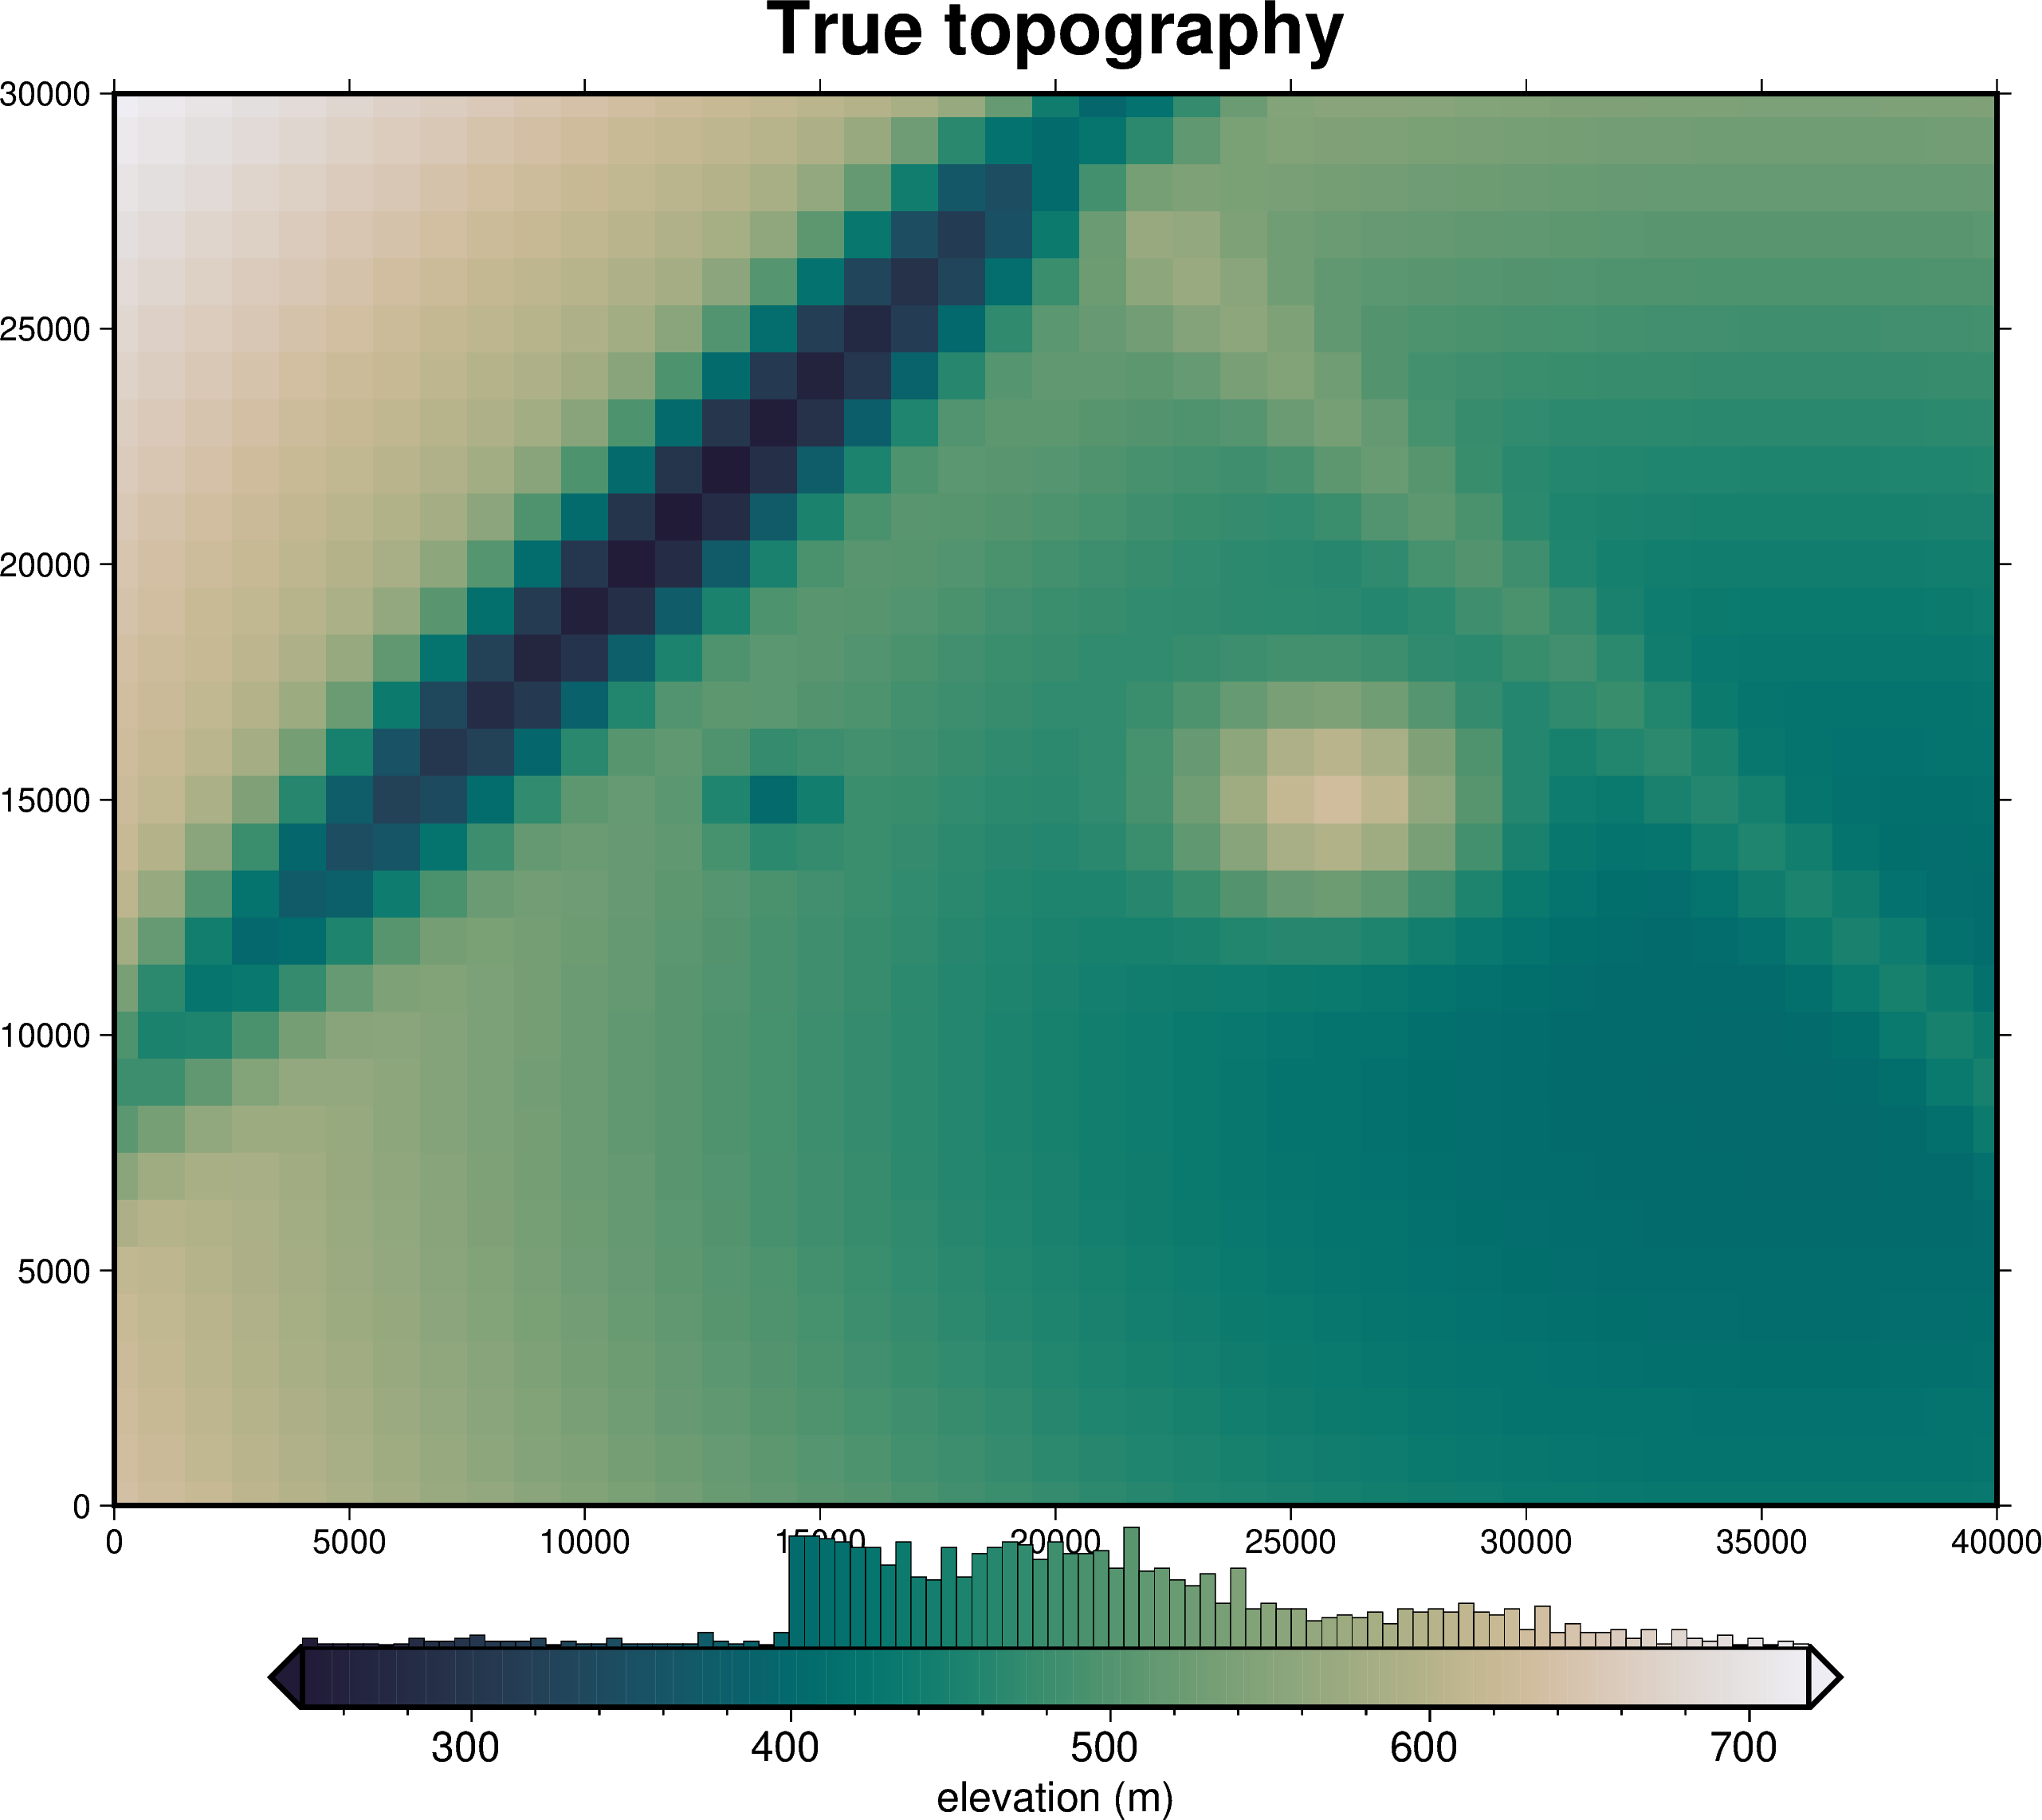

<xarray.DataArray 'upward' (northing: 31, easting: 41)> Size: 10kB
array([[637.12943453, 627.28784729, 617.55840384, ..., 428.39025144,
        429.33158321, 430.64751872],
       [632.95724141, 623.04617819, 613.24496334, ..., 422.67589466,
        423.6241977 , 424.94987872],
       [629.2139621 , 619.27333357, 609.41212904, ..., 417.59868139,
        418.55317844, 419.88752006],
       ...,
       [701.54094486, 692.82534357, 684.20926165, ..., 516.68829114,
        517.52190298, 518.68725132],
       [709.90739328, 701.33808009, 692.86661587, ..., 528.15742206,
        528.97704204, 530.12283044],
       [718.55151946, 710.13334959, 701.81130286, ..., 540.00720706,
        540.8123708 , 541.93795008]])
Coordinates:
  * easting   (easting) float64 328B 0.0 1e+03 2e+03 ... 3.8e+04 3.9e+04 4e+04
  * northing  (northing) float64 248B 0.0 1e+03 2e+03 ... 2.8e+04 2.9e+04 3e+04

In [2]:
spacing = 1000
region = (0, 40000, 0, 30000)

true_topography, _, _, _ = synthetic.load_synthetic_model(
    spacing=spacing,
    region=region,
)

# plot the true topography
fig = maps.plot_grd(
    true_topography,
    title="True topography",
    cmap="rain",
    reverse_cpt=True,
    hist=True,
    cbar_yoffset=1.5,
    cbar_label="elevation (m)",
    frame=["nSWe", "xaf10000", "yaf10000"],
)
fig.show()

true_topography

### Prism layer

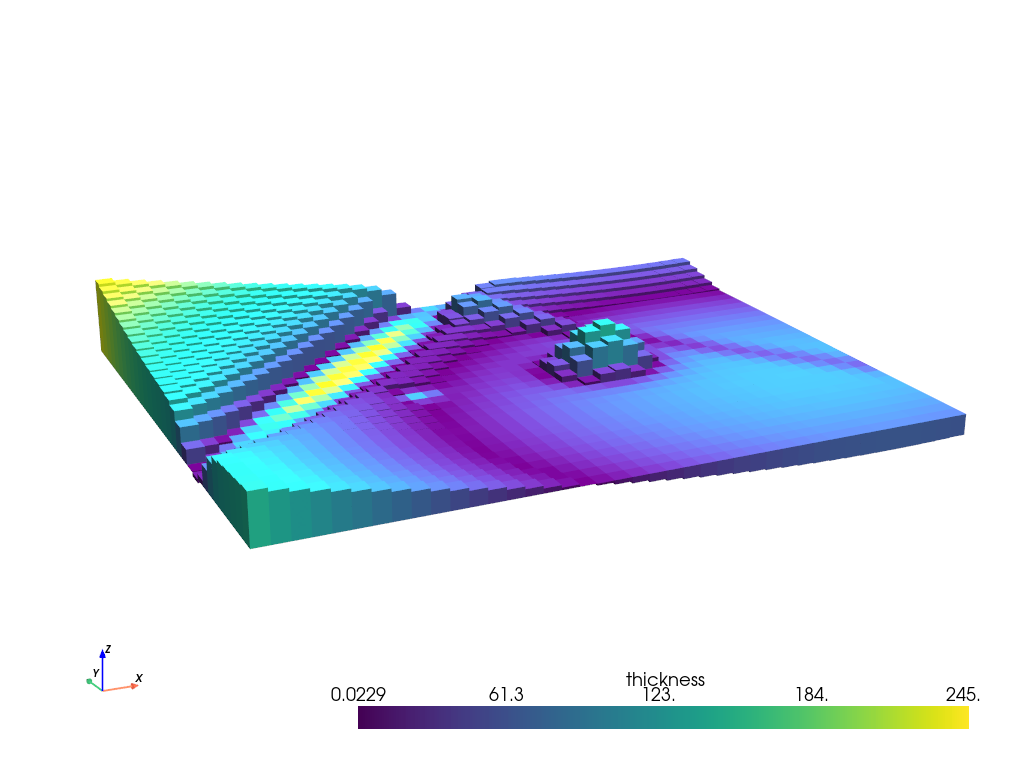

mean topography is 492.2704164812973 m


In [3]:
# the density contrast is between rock (~2670 kg/m3) and air (~1 kg/m3)
density_contrast = 2670 - 1

# prisms are created between the mean topography value and the height of the topography
zref = true_topography.values.mean()

# prisms above zref have positive density contrast and prisms below zref have negative
# density contrast
density_grid = xr.where(true_topography >= zref, density_contrast, -density_contrast)

# create layer of prisms
prisms = utils.grids_to_prisms(
    true_topography,
    zref,
    density=density_grid,
)

plotting.show_prism_layers(
    prisms,
    color_by="thickness",
    log_scale=False,
    zscale=20,
    backend="static",
)

print(f"mean topography is {prisms.attrs.get('zref')} m")

### Forward gravity of prism layer
Below we use the Python package `Harmonica` to calculate the gravity effect of this layer of prisms on some defined observation points. This will act as our observed gravity data.

In [4]:
# make pandas dataframe of locations to calculate gravity
# this represents the station locations of a gravity survey
# create lists of coordinates
coords = vd.grid_coordinates(
    region=region,
    spacing=spacing,
    pixel_register=False,
    extra_coords=1000,  # survey elevation
)

# grid the coordinates
observations = vd.make_xarray_grid(
    (coords[0], coords[1]),
    data=coords[2],
    data_names="upward",
    dims=("northing", "easting"),
).upward

grav_df = vd.grid_to_table(observations)

grav_df["grav"] = prisms.prism_layer.gravity(
    coordinates=(
        grav_df.easting,
        grav_df.northing,
        grav_df.upward,
    ),
    field="g_z",
    progressbar=True,
)

grav_df.describe()

  0%|          | 0/1271 [00:00<?, ?it/s]

,northing,easting,upward,grav
count,1271.000000,1271.00000,1271.0,1271.000000
mean,15000.000000,20000.00000,1000.0,-0.129304
std,8947.792584,11836.81698,0.0,7.149948
min,0.000000,0.00000,1000.0,-17.191726
25%,7000.000000,10000.00000,1000.0,-5.539102
50%,15000.000000,20000.00000,1000.0,-1.136975
75%,23000.000000,30000.00000,1000.0,3.746123
max,30000.000000,40000.00000,1000.0,19.590234


INFO:invert4geom:Standard deviation used for noise: [0.2]


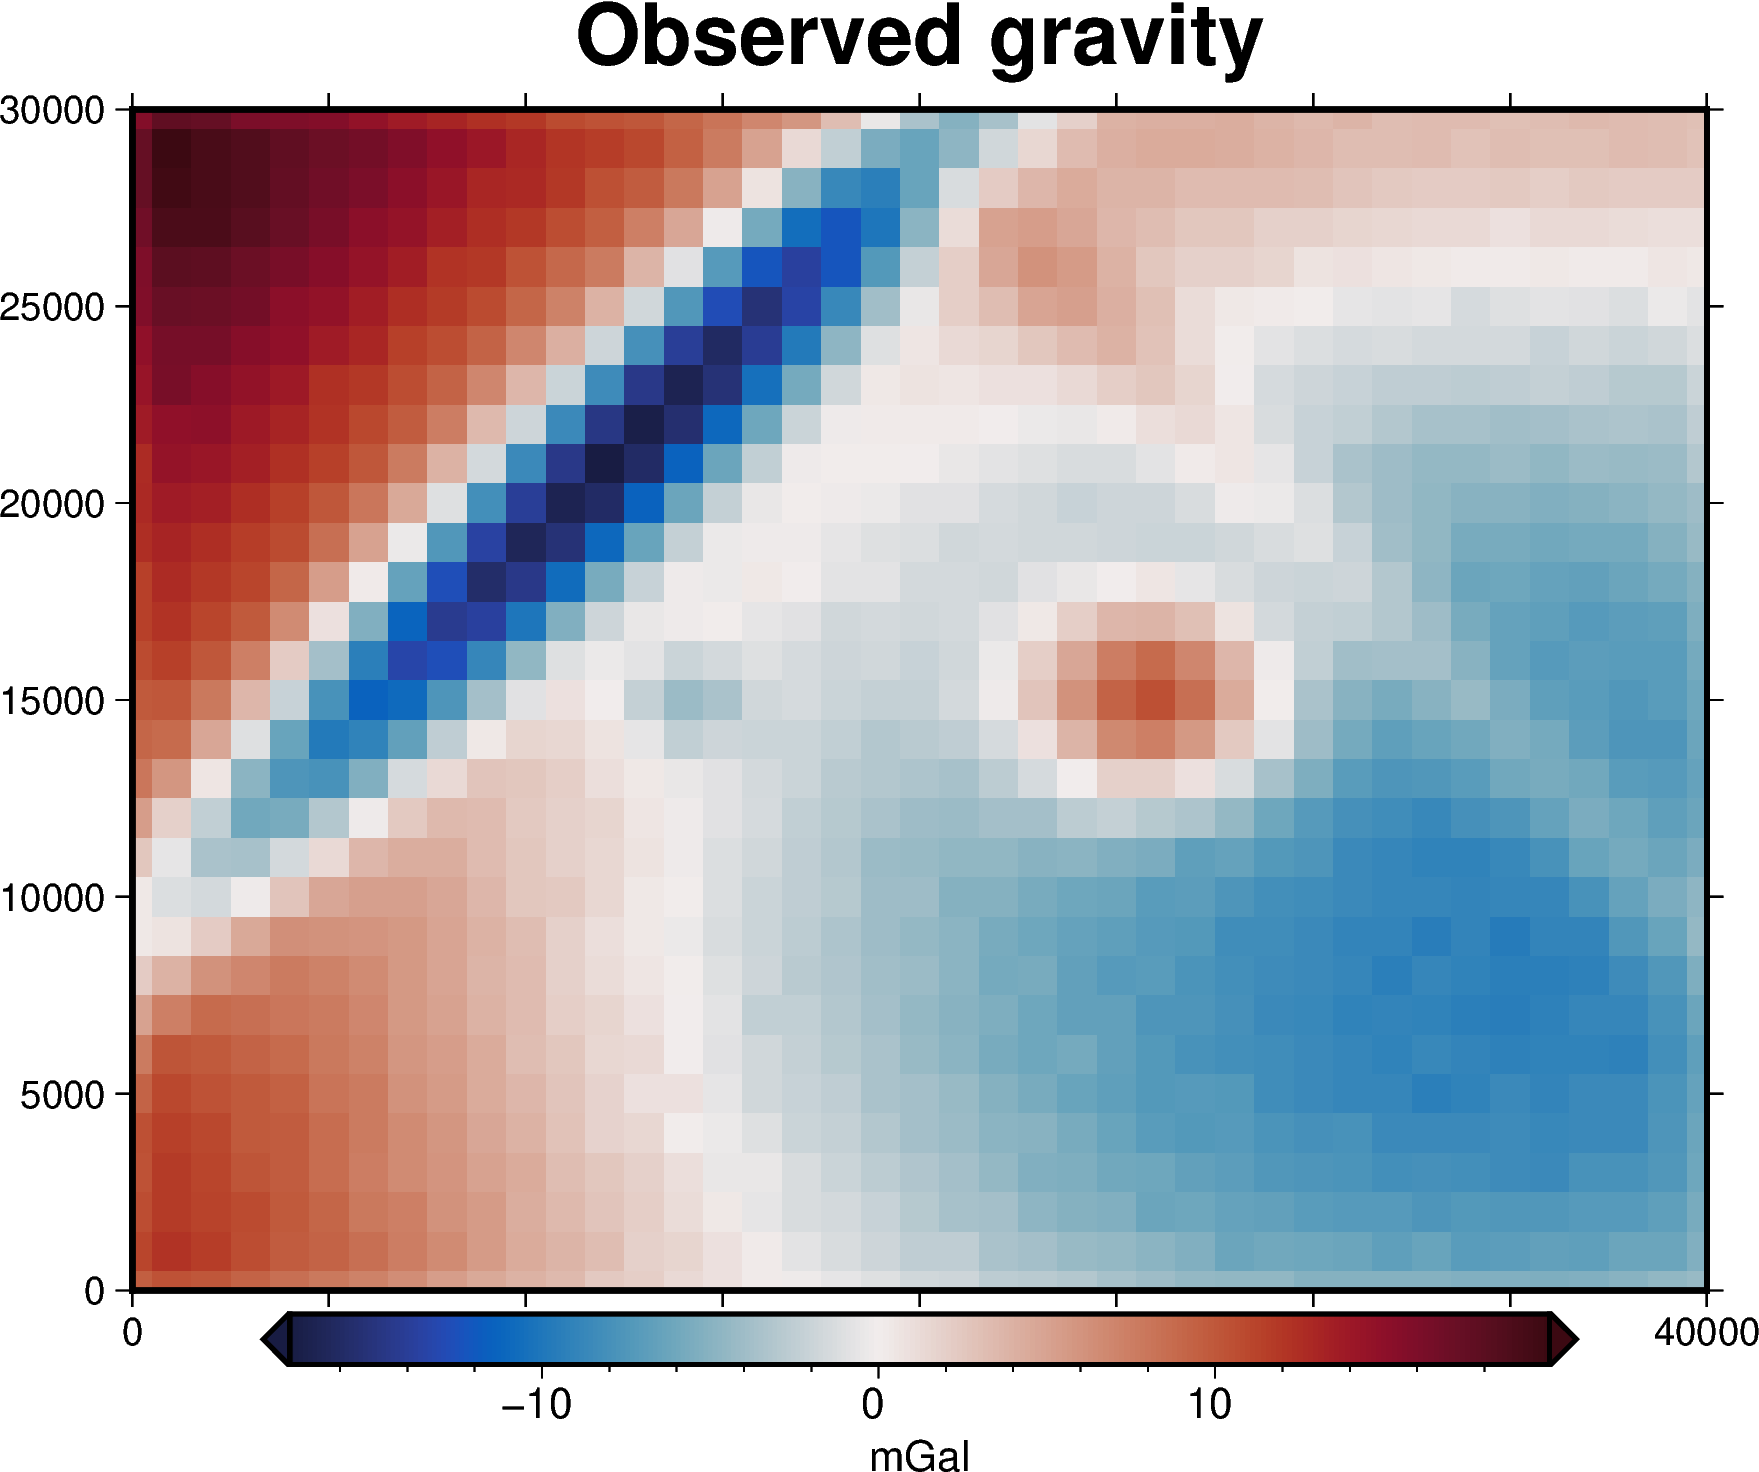

In [5]:
# contaminate gravity with 0.2 mGal of random noise
grav_df["gravity_anomaly"], stddev = synthetic.contaminate(
    grav_df.grav,
    stddev=0.2,
    percent=False,
    seed=0,
)

# plot the observed gravity
fig = maps.plot_grd(
    grav_df.set_index(["northing", "easting"]).to_xarray().gravity_anomaly,
    fig_height=10,
    title="Observed gravity",
    cmap="balance+h0",
    grd2_cpt=True,
    cbar_label="mGal",
    frame=["nSWe", "xaf10000", "yaf10000"],
)
fig.show()

## Gravity misfit
Now we need to create a starting model of the topography to start the inversion with. Since here we have no knowledge of either the topography or the appropriate reference level (`zref`), the starting model is flat, and therefore it's forward gravity is 0. If you had a non-flat starting model, you would need to calculate it's forward gravity effect, and subtract it from our observed gravity to get a starting gravity misfit. 

In this simple case, we assume that we know the true density contrast and appropriate reference value for the topography (`zref`), and use these values to create our flat starting model. Note that in a real world scenario, these would be unknowns which would need to be carefully chosen, as explained in the following notebooks.

In [6]:
# create flat topography grid with a constant height
starting_topography = xr.full_like(true_topography, zref)

# prisms are created between zref and the height of the topography, which for this
# starting model is flat.
# prisms above zref have positive density contrast and prisms below zref have negative
# density contrast
density_grid = xr.where(
    starting_topography >= zref, density_contrast, -density_contrast
)

# create flat layer of prisms
starting_prisms = utils.grids_to_prisms(
    starting_topography,
    zref,
    density=density_grid,
)

In [7]:
# since our starting model is flat, the starting gravity is 0
grav_df["starting_gravity"] = 0

# in many cases, we want to remove a regional signal from the misfit to isolate the
# residual signal. In this simple case, we assume there is no regional misfit and set
# it to 0.
# the function below will subtract the column 'starting_gravity' from 'gravity_anomaly'
# to create 'misfit'. The 'reg' column (chosen here to be 0) is then subtracted from
# 'misfit' to get 'res', the residual gravity misfit.
grav_df = regional.regional_separation(
    method="constant",
    constant=0,
    grav_df=grav_df,
)

grav_df.describe()

,northing,easting,upward,grav,gravity_anomaly,starting_gravity,misfit,reg,res
count,1271.000000,1271.00000,1271.0,1271.000000,1271.000000,1271.0,1271.000000,1271.0,1271.000000
mean,15000.000000,20000.00000,1000.0,-0.129304,-0.129304,0.0,-0.129304,0.0,-0.129304
std,8947.792584,11836.81698,0.0,7.149948,7.148580,0.0,7.148580,0.0,7.148580
min,0.000000,0.00000,1000.0,-17.191726,-17.498175,0.0,-17.498175,0.0,-17.498175
25%,7000.000000,10000.00000,1000.0,-5.539102,-5.603815,0.0,-5.603815,0.0,-5.603815
50%,15000.000000,20000.00000,1000.0,-1.136975,-1.150991,0.0,-1.150991,0.0,-1.150991
75%,23000.000000,30000.00000,1000.0,3.746123,3.750980,0.0,3.750980,0.0,3.750980
max,30000.000000,40000.00000,1000.0,19.590234,19.930660,0.0,19.930660,0.0,19.930660


## Perform inversion
Now that we have a starting model and residual gravity misfit data we can start the inversion. There are many arguments you can pass to `run_inversion`, here we just include the basics. We add some smoothness regularization to the inversion to ensure the results are reasonably smooth, this is with the parameter `solver_damping`. We also set the stopping criteria:
* `max_iterations` is just a safety mechanism to avoid very long running inversions, this should be set high to avoid early termination. 
* `l2_norm_tolerance` defines when the inversion should end based on l2-norm of the residual gravity misfit. Here, we added 0.2 mGal of noise to the gravity data, so we want the inversion to stop when the residual misfit gets to around 0.2 mGal. The l2-norm is the square-root of the misfit, so about a value of 0.45. 
* `delta_l2_norm_tolerance` defines when the inversion should end if it is not making any significant progress. A value of 1 means the l2-norm has not changed from the past iteration, while a value of 1.005 means the l2-norm has decreased by ~.5%.

INFO:invert4geom:starting inversion


Iteration:   0%|          | 1/200 [00:00<?, ?it/s]

INFO:invert4geom:
 #################################### 
 iteration 1
INFO:invert4geom:Layer correction median: -5.685081 m, RMSE:33.469678 m
INFO:invert4geom:updated misfit RMSE: 4.079617
INFO:invert4geom:updated L2-norm: 2.019806, tolerance: 0.45
INFO:invert4geom:updated delta L2-norm : 1.32358, tolerance: 1.005
INFO:invert4geom:
 #################################### 
 iteration 2
INFO:invert4geom:Layer correction median: 12.534432 m, RMSE:18.692893 m
INFO:invert4geom:updated misfit RMSE: 2.418863
INFO:invert4geom:updated L2-norm: 1.555269, tolerance: 0.45
INFO:invert4geom:updated delta L2-norm : 1.298686, tolerance: 1.005
INFO:invert4geom:
 #################################### 
 iteration 3
INFO:invert4geom:Layer correction median: 6.92392 m, RMSE:10.760145 m
INFO:invert4geom:updated misfit RMSE: 1.508073
INFO:invert4geom:updated L2-norm: 1.228036, tolerance: 0.45
INFO:invert4geom:updated delta L2-norm : 1.266468, tolerance: 1.005
INFO:invert4geom:
 #################################

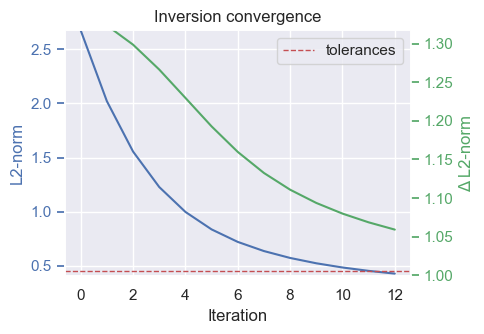

In [8]:
# run the inversion
results = inversion.run_inversion(
    grav_df=grav_df,
    prism_layer=starting_prisms,
    solver_damping=0.1,
    # set stopping criteria
    max_iterations=200,
    l2_norm_tolerance=0.45,
    delta_l2_norm_tolerance=1.005,
    # show a plot of the inversion's convergence
    plot_convergence=True,
)

# collect the results
topo_results, grav_results, parameters, elapsed_time = results

The above plot shows how the l2-norm and delta l2-norm have been reduced during the inversion. The red line at the bottom marks the set tolerances for each of these. This show that the inversion terminated at the 12 inversion since the l2-norm was lower than the set l2-norm tolerance. 

The below three plots show:
1) a comparison of the starting topography (flat) and the final inverted topography
2) a comparison of the residual gravity misfit before and after the inversion
3) the results of 4 of the 12 iterations where the left column shows that iterations starting residual misfit, the middle column shows the current state of the topography, and the right column shows the correction that was applied to the topography during that iteration

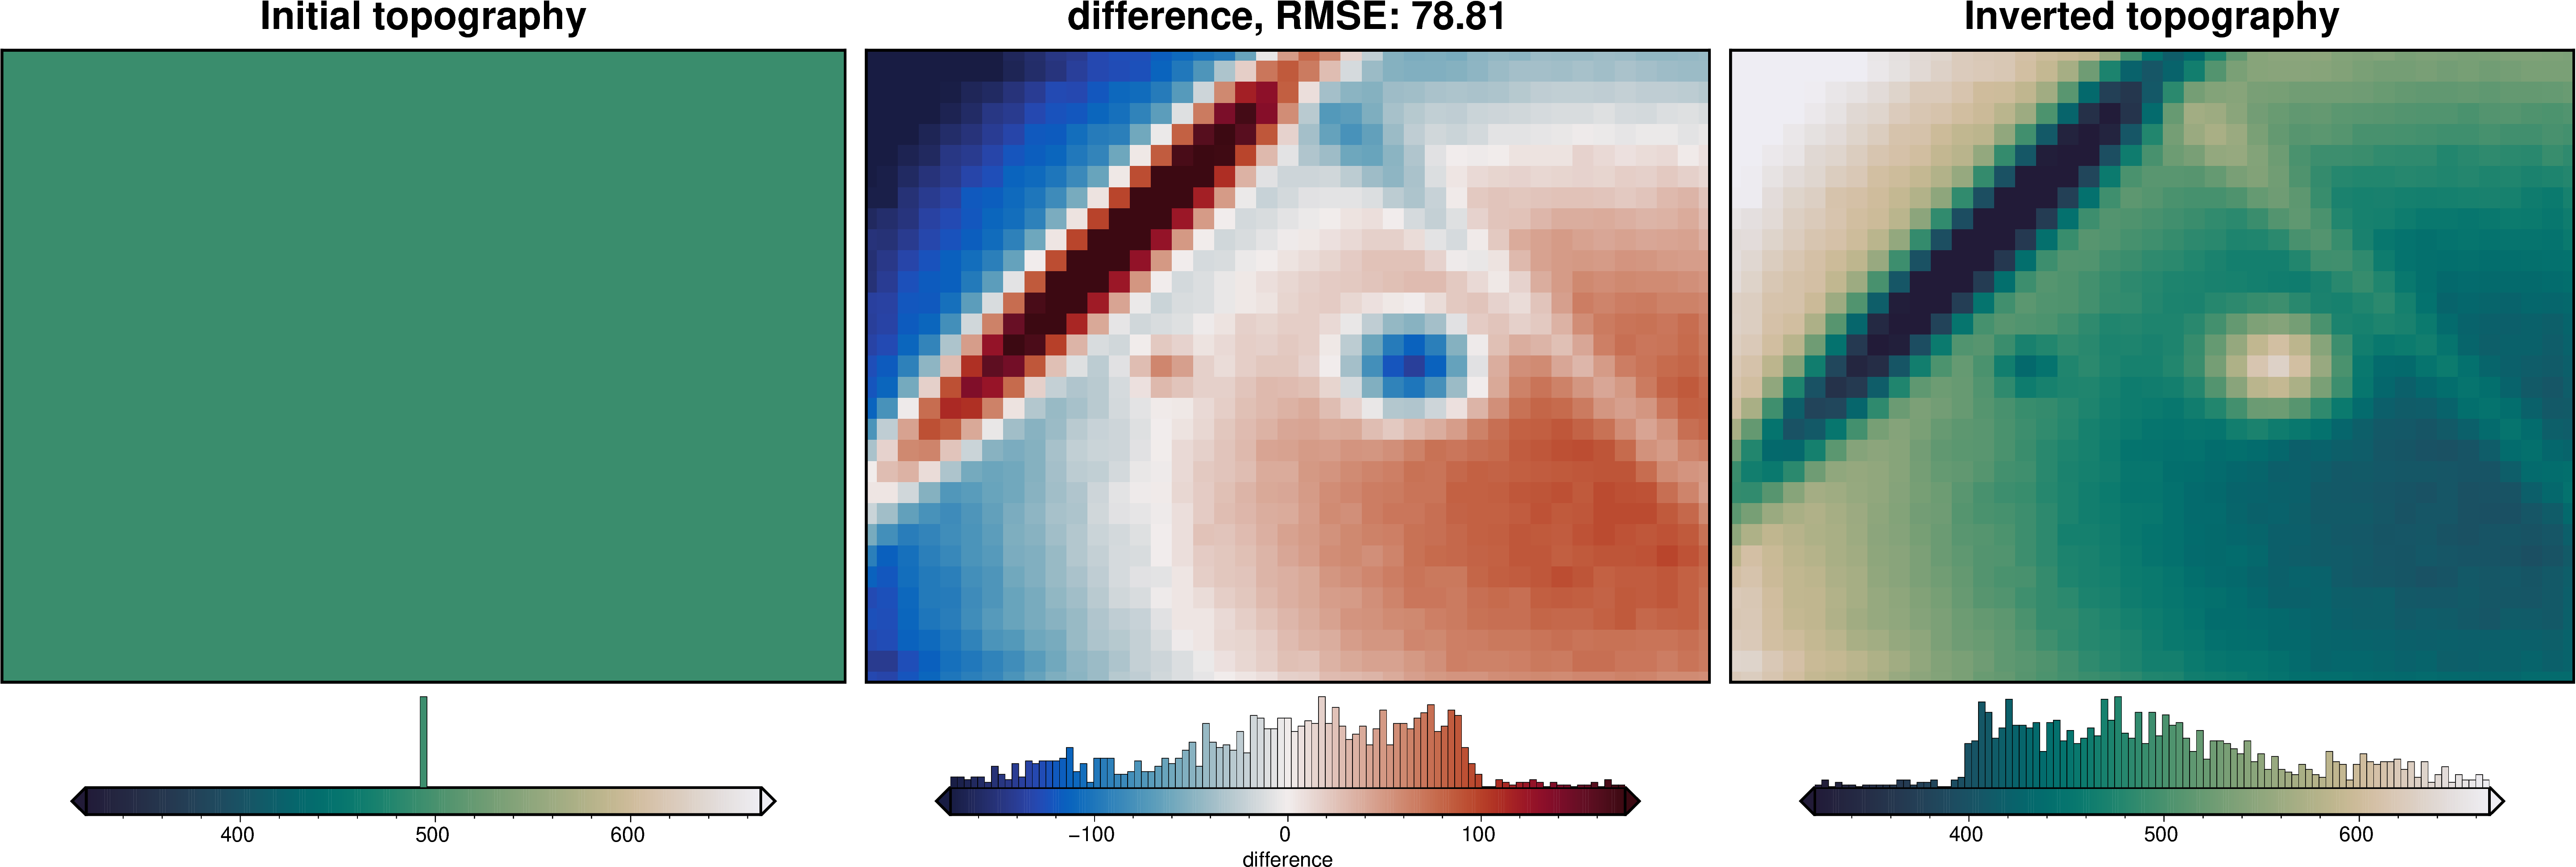

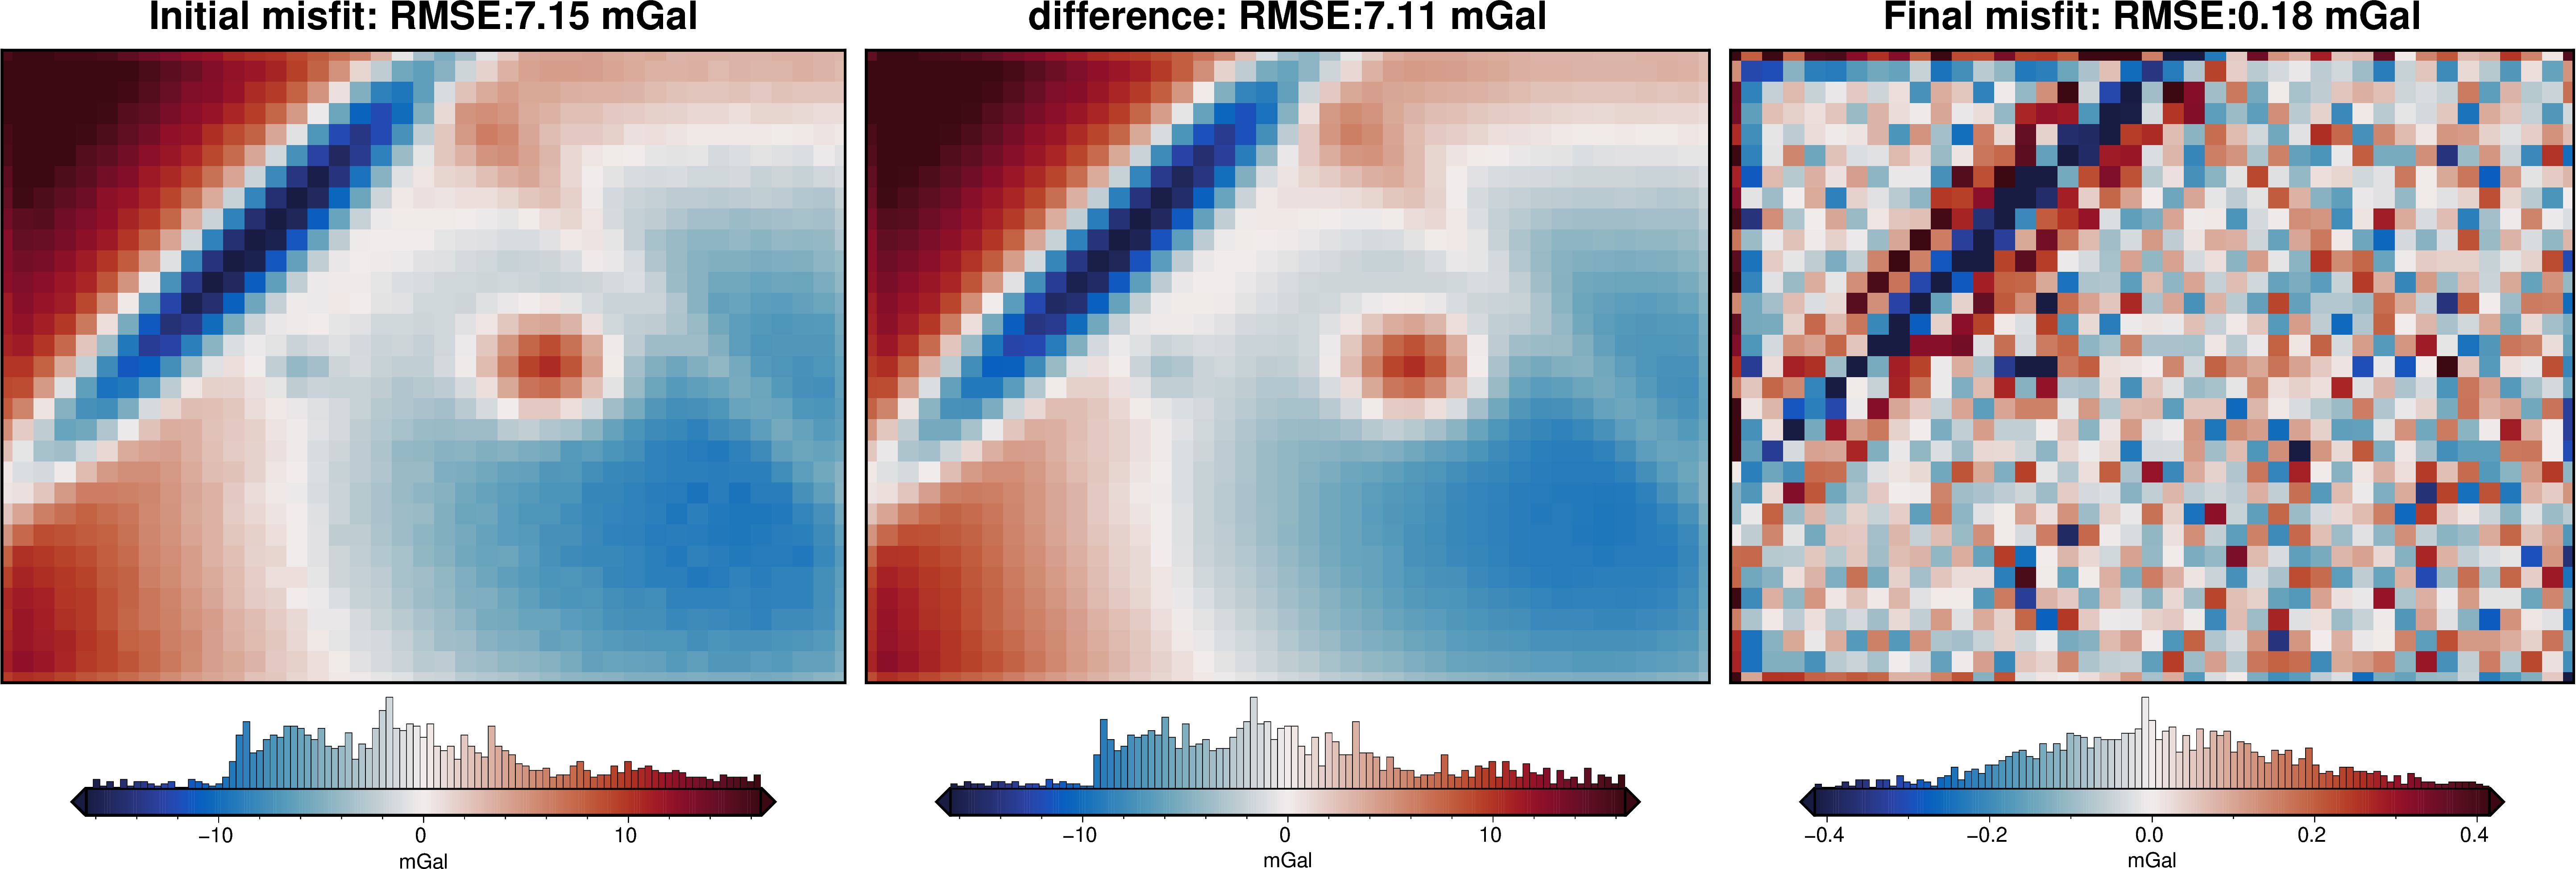

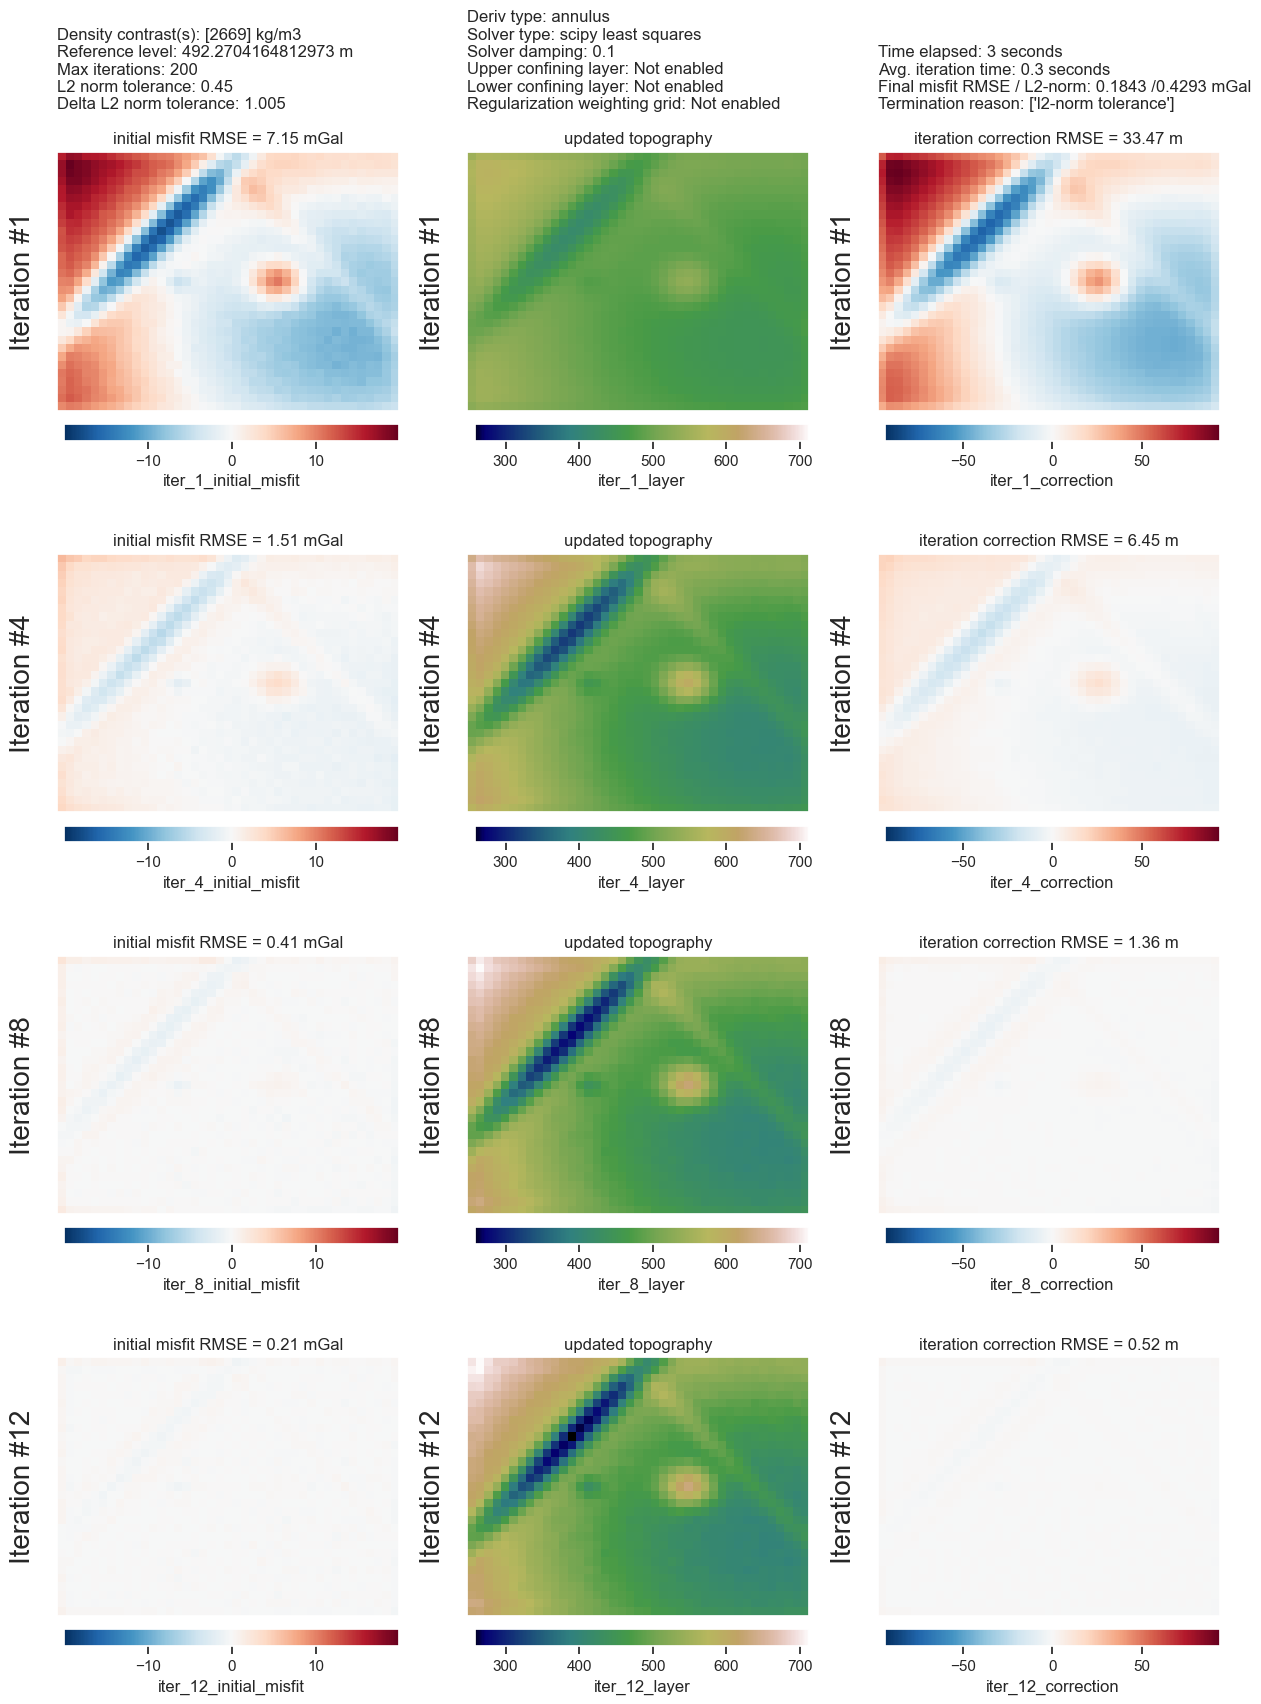

In [9]:
plotting.plot_inversion_results(
    grav_results,
    topo_results,
    parameters,
    region,
    iters_to_plot=4,
    plot_iter_results=True,
    plot_topo_results=True,
    plot_grav_results=True,
)

Below we compare the true topography with the results of the inversion to see how it performed. In this example, we assumed we knew the correct density contrast value and zref, and added minimal noise to the observed gravity, so we expect the inversion to accurately recover the true topography.

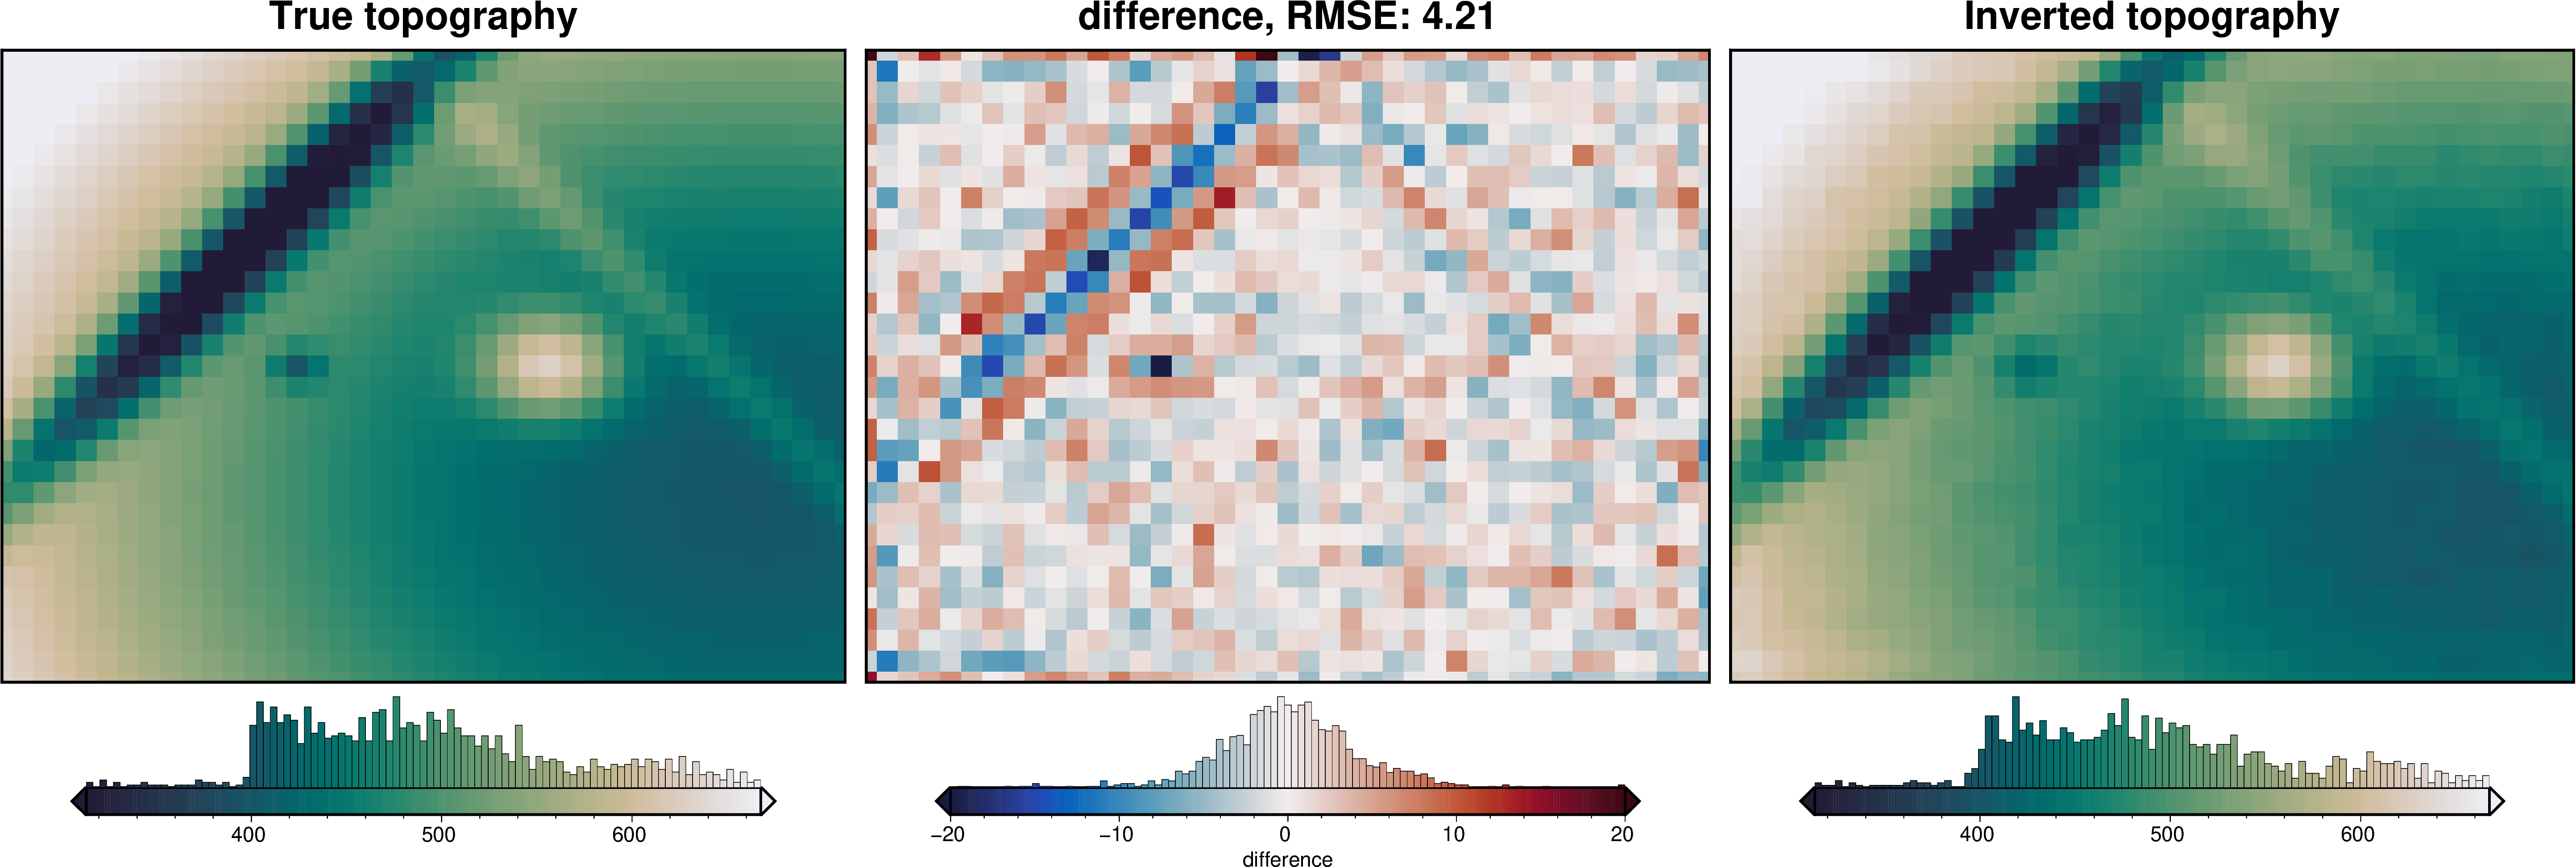

In [10]:
final_topography = topo_results.set_index(["northing", "easting"]).to_xarray().topo

_ = polar_utils.grd_compare(
    true_topography,
    final_topography,
    # plot_type="xarray",
    plot=True,
    grid1_name="True topography",
    grid2_name="Inverted topography",
    robust=True,
    hist=True,
    inset=False,
    verbose="q",
    title="difference",
    grounding_line=False,
    reverse_cpt=True,
    cmap="rain",
    diff_lims=(-20, 20),
)

As you can see, the inversion successfully recovered the true topography. The root mean square difference between the true and recovered topography is low, but this is not too suprising since we gave the inversion the true density contrast and appropriate zref value.

See `reference_level_cross_validation.ipynb` and `density_cross_validation.ipynb` for examples of how to best choose those values in scenarios where you don't know them.

The next notebook, `damping_cross_validation.ipynb` will explain how to use cross validation to choose the optimal damping parameter value. Here, we simply chose an arbitrary value which appeared to work well. With real data with noise, this choice of the damping parameter becomes very important. 